In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import cheby1, freqz

from Functions.daub_5_3_lift import daub_5_3_lift
from Functions.idaub_5_3_lift import idaub_5_3_lift
from Functions.daub_5_3_lift_2D import daub_5_3_lift_2D
from Functions.idaub_5_3_lift_2D import idaub_5_3_lift_2D

In [2]:
user_figsize = (12, 6)
user_frsize = (12,8)
user_fontsize = 14
user_ylabel = ['Magnitude, db', 'Phase, deg']

In [3]:
F_SAMPLE = 102400
T_SAMPLE = 1/F_SAMPLE

F_LOW = 100
H_WINDOW = 1/F_LOW

T_FULL = 4*H_WINDOW

N_POINT = int(T_FULL/T_SAMPLE+0.5)
N_FFT = int(H_WINDOW/T_SAMPLE+0.5)
print(N_FFT)

1024


Синтез фильтра

In [4]:
# Crossover frequency.
fc = 1e3

filter_order = 2
filter_mag = 5

b, a = cheby1(filter_order, filter_mag, fc/(F_SAMPLE/2), btype='low')

Частотная характеристика синтезированного фильтра

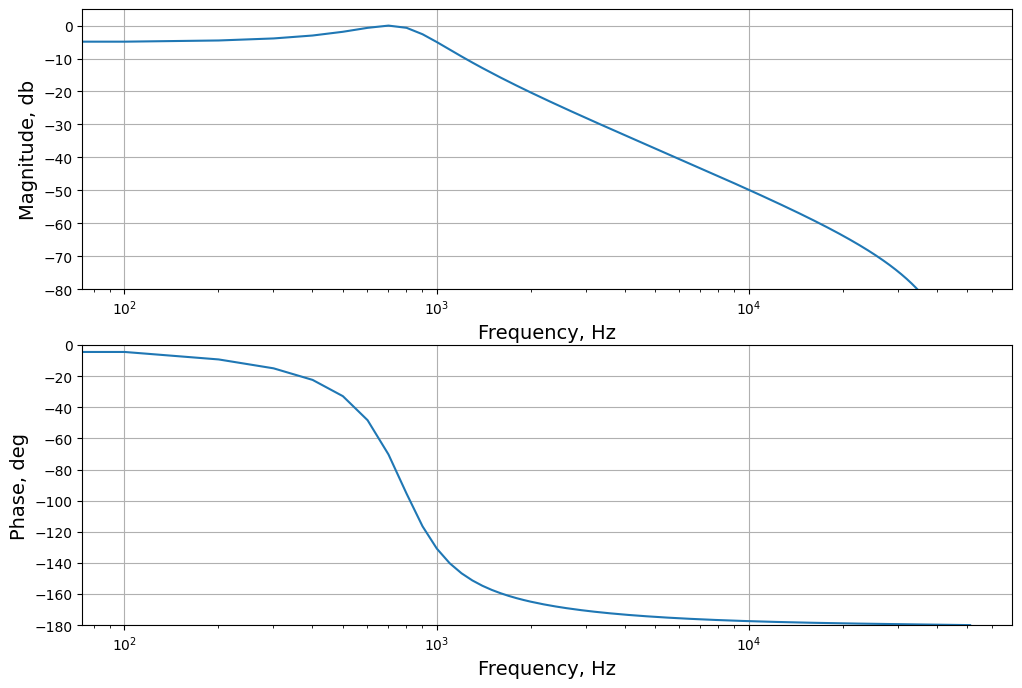

In [5]:
freq_graph = np.linspace(0, F_SAMPLE/2, N_FFT//2)

_, h = freqz(b, a, worN=N_FFT//2)
filter_abs_phase = [20*np.log10(np.abs(h)), np.unwrap(np.angle(h))*180/np.pi]

user_ylim = [[-80, 5], [-180, 0]]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable in zip(axes, filter_abs_phase, user_ylim, user_ylabel):
    ax.plot(freq_graph, plot_var)
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.grid(True)
plt.show()

Массив инжектируемых частот

In [6]:
N_FREQ = int(F_SAMPLE/2/F_LOW) - 1
freq = np.linspace(F_LOW, F_SAMPLE/2-F_LOW, N_FREQ)

Набор сигналов инжекции

In [7]:
t = np.linspace(0, T_FULL-T_SAMPLE, N_POINT)

Xm = 3
phi_x = np.pi/6
NOISE_MAG = 0.01 * Xm

x = np.empty((N_FREQ,), dtype=object)
for k, f in enumerate(freq):
    x[k] = Xm * np.cos(2*np.pi*f*t + phi_x) + np.random.normal(0, NOISE_MAG, N_POINT)

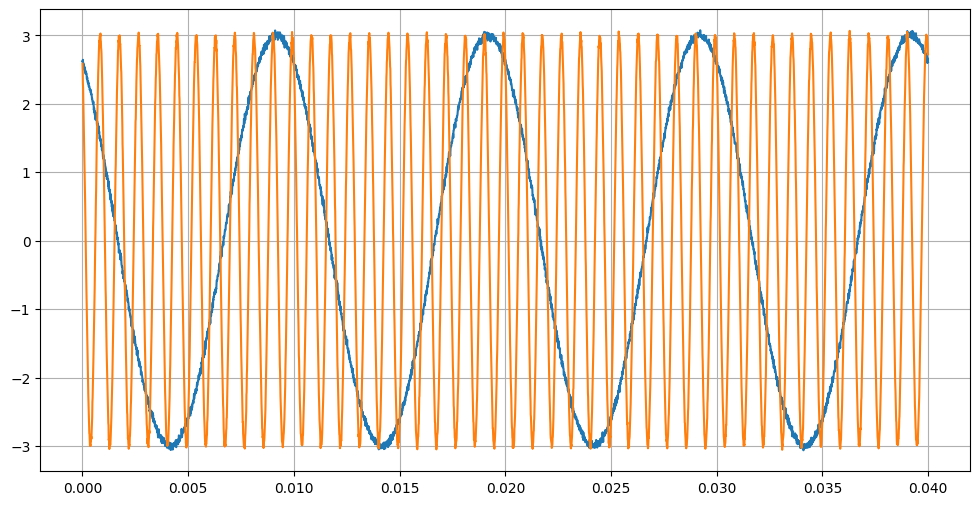

In [8]:
plt.figure(figsize=user_figsize)
plt.plot(t,x[0])
plt.plot(t,x[10])
plt.grid(True)
plt.show()

Модель динамической системы

In [9]:
def IIR_filter(x, b_coeff, a_coeff):
    # Создаем список из нулей.
    y = [0] * len(x)
    for k in range(len(x)):
        for m, b in enumerate(b_coeff):
            if (k-m) >= 0:
                y[k] += b * x[k-m]
        for n, a in enumerate(a_coeff[1:], start=1):
            if (k-n) >= 0:
                y[k] -= a * y[k-n]
    return y

Выходной сигнал системы

In [10]:
y = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    y[k] = IIR_filter(xf, b, a)

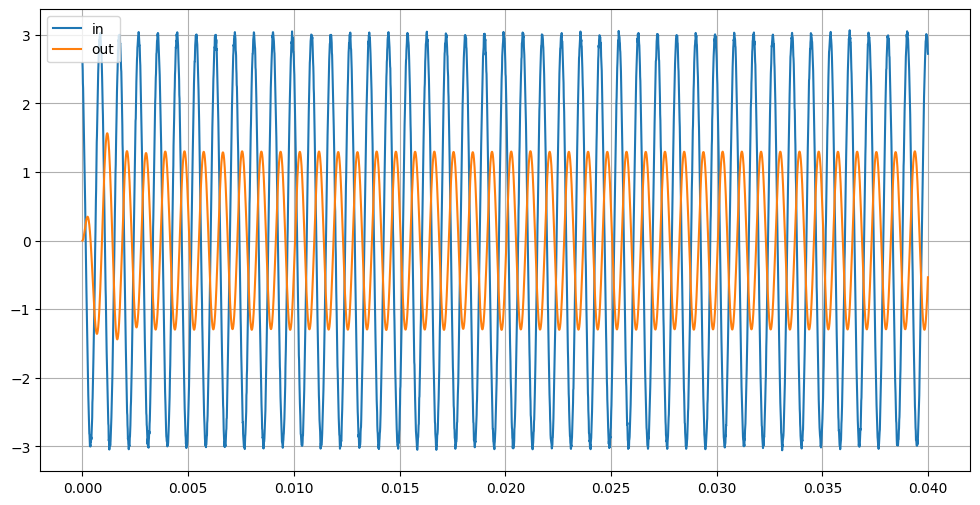

In [11]:
plt.figure(figsize=user_figsize)
plt.plot(t,x[10], label='in')
plt.plot(t,y[10], label='out')
plt.legend()
plt.grid(True)
plt.show()

Частотная характеристика

In [12]:
def freq_resp(x, y, N_FREQ):
    complex_gain = np.zeros((N_FREQ,), dtype=complex)

    for k in range(N_FREQ):
        Xfft = np.fft.fft(x[k][-N_FFT:])[:N_FFT//2]
        Yfft = np.fft.fft(y[k][-N_FFT:])[:N_FFT//2]
        complex_gain[k] = Yfft[k+1]/Xfft[k+1]
    return complex_gain

In [13]:
complex_gain = freq_resp(x, y, N_FREQ)
gain_abs_arg = [20*np.log10(np.abs(complex_gain)), np.unwrap(np.angle(complex_gain))*180/np.pi]

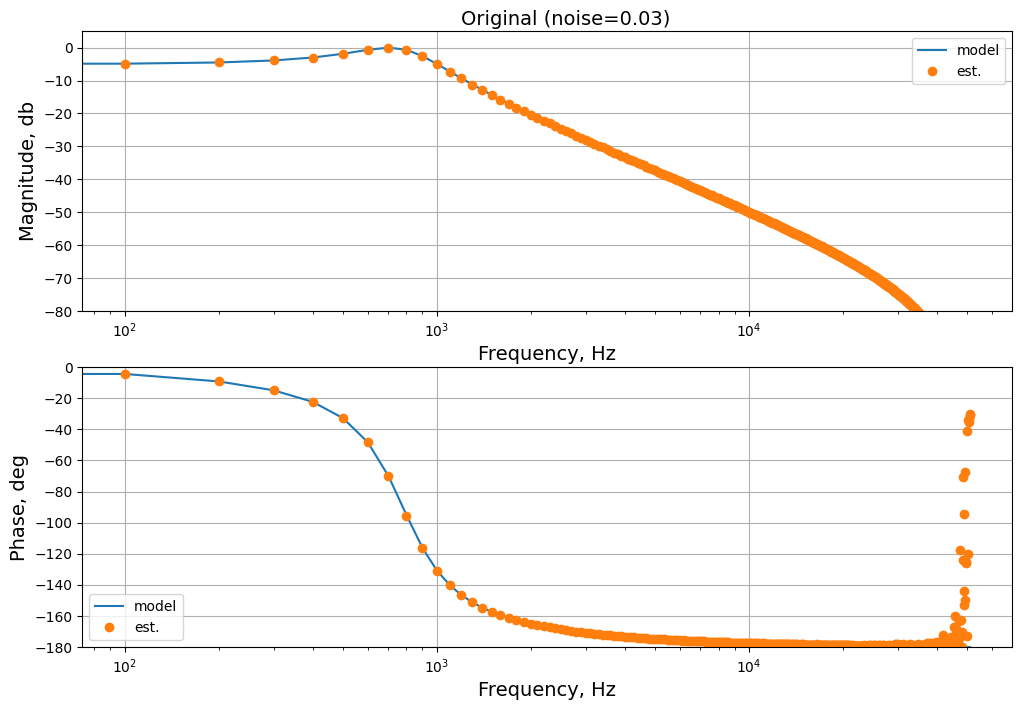

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Original (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

In [15]:
x_compr = np.empty((N_FREQ,), dtype=object)
y_compr = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x):
    x_coeff = daub_5_3_lift(xf[-N_FFT:], int_flag=False)
    x_coeff[-N_FFT//2:] = 0
    x_compr[k] = idaub_5_3_lift(x_coeff, int_flag=False)

for k, yf in enumerate(y):
    y_coeff = daub_5_3_lift(np.array(yf[-N_FFT:]), int_flag=False)
    y_coeff[-N_FFT//2:] = 0
    y_compr[k] = idaub_5_3_lift(y_coeff, int_flag=False)

complex_gain_compr = freq_resp(x_compr, y_compr, N_FREQ)
gain_abs_arg_compr = [20*np.log10(np.abs(complex_gain_compr)), np.unwrap(np.angle(complex_gain_compr))*180/np.pi]

In [16]:
print(np.array(x_compr[0]).shape)

(1024,)


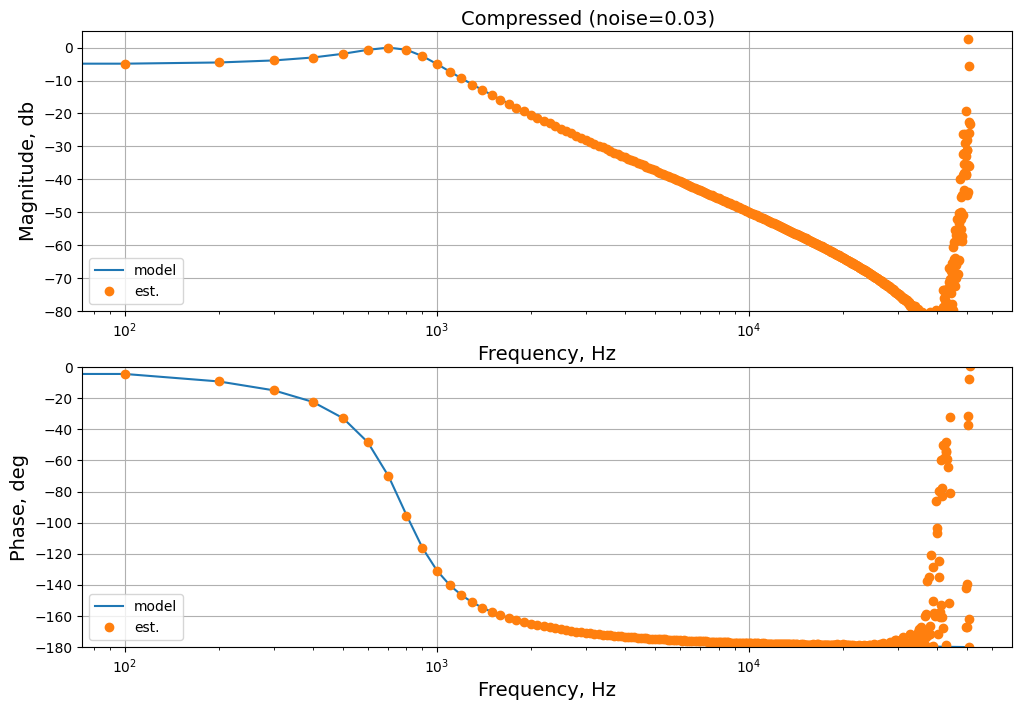

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

Двумерное преобразование

In [18]:
x_sq = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    x_sq[k] = xf[-N_FFT:].reshape(32, -1)

y_sq = np.empty((N_FREQ,), dtype=object)
for k, yf in enumerate(y):
    y_sq[k] = np.array(yf[-N_FFT:]).reshape(32, -1)

In [29]:
x_compr_2D = np.empty((N_FREQ,), dtype=object)
y_compr_2D = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x_sq):
    x_coeff = np.zeros((32,32))
    x_coeff[-16:,:16] = daub_5_3_lift_2D(xf, int_flag=False)[-16:,:16]
    x_compr_2D[k] = idaub_5_3_lift_2D(x_coeff, int_flag=False).ravel()

for k, yf in enumerate(y_sq):
    y_coeff = np.zeros((32,32))
    y_coeff[-16:,:16] = daub_5_3_lift_2D(yf, int_flag=False)[-16:,:16]
    y_compr_2D[k] = idaub_5_3_lift_2D(y_coeff, int_flag=False).ravel()

complex_gain_compr_2D = freq_resp(x_compr_2D, y_compr_2D, N_FREQ)
gain_abs_arg_compr_2D = [20*np.log10(np.abs(complex_gain_compr_2D)), np.unwrap(np.angle(complex_gain_compr_2D))*180/np.pi]

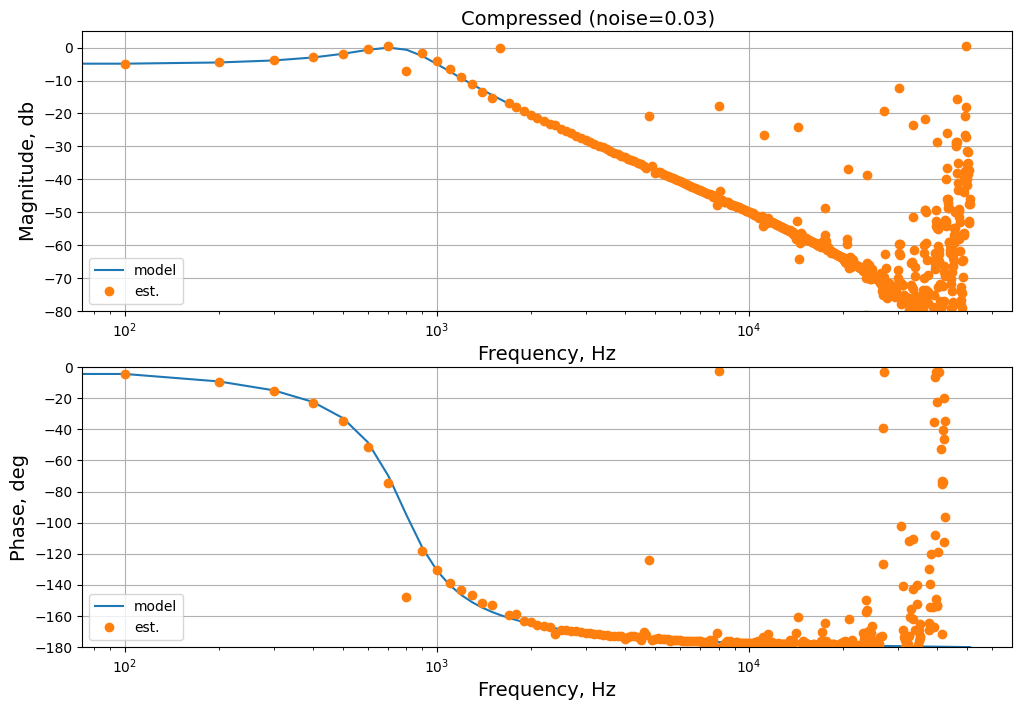

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr_2D):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

In [21]:
print(np.abs(Xfft[int(freq_inj/F_LOW)]), np.angle(Xfft[int(freq_inj/F_LOW)]), phi_x)
print(np.abs(Yfft[int(freq_inj/F_LOW)]), np.angle(Yfft[int(freq_inj/F_LOW)]))
print(np.abs(Yfft[int(freq_inj/F_LOW)])/np.abs(Xfft[int(freq_inj/F_LOW)]), np.angle(Yfft[int(freq_inj/F_LOW)])-np.angle(Xfft[int(freq_inj/F_LOW)]))


Xfft_compr = np.fft.fft(x_compr[-N_FFT:])[:N_FFT//2] / (N_FFT/2)
Yfft_compr = np.fft.fft(y_compr[-N_FFT:])[:N_FFT//2] / (N_FFT/2)

NameError: name 'Xfft' is not defined

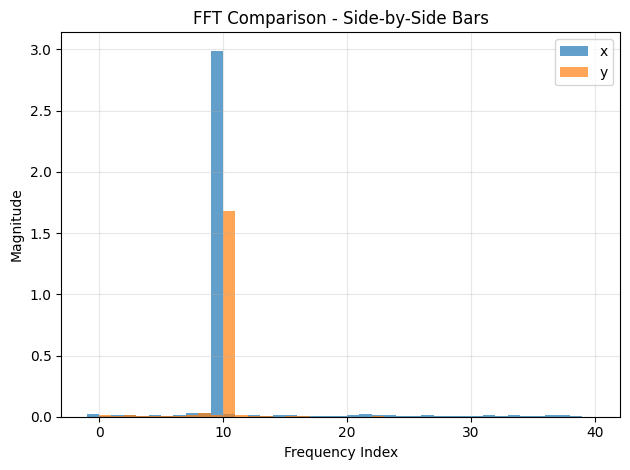

In [ ]:
N_FREQ = 40
# Bar width and positions
width = 1.0
x_pos = np.arange(len(freq[:N_FREQ]))

plt.bar(x_pos - width/2, np.abs(Xfft[:N_FREQ]), width, label='x', alpha=0.7)
plt.bar(x_pos + width/2, np.abs(Yfft[:N_FREQ]), width, label='y', alpha=0.7)

plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.title('FFT Comparison - Side-by-Side Bars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
g = np.random.randint(low=-10, high=11, size=8*8).reshape(8,8)
#g[:4,4:] = 0
display(g[-4:,:4])

array([[ 10,  -1,  10,   2],
       [ -2,  -8,   2,   1],
       [-10,   4,   7,  -5],
       [ -5,  -9,  -9,  -2]])